# Comparing to N-body integrations

To facilitate comparison to N-body integrations, we have made a simple `Nbody` wrapper class, which simply initializes a `REBOUND` N-body integration with the same parameters we use for our classifier, and provides the same interface.

Let's set up the same Simulation as in the Quickstart example:

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


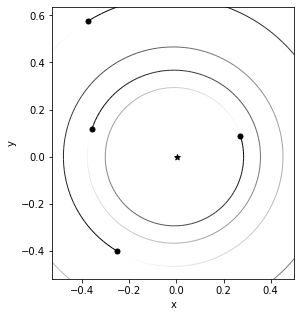

In [1]:
import rebound
%matplotlib inline

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1.e-4, P=1., e=0.03, l=0.3)
sim.add(m=1.e-4, P=1.4, e=0.03, l=2.8)
sim.add(m=1.e-4, P=2, e=0.03, l=4.2)
sim.add(m=1.e-4, P=3.5, e=0.03, l=2.1)
sim.move_to_com()
fig = rebound.OrbitPlot(sim)

The interface is the same:

In [2]:
from spock import StabilityClassifier
sc = StabilityClassifier()

from spock import Nbody
nbody = Nbody()

In [3]:
%%time
sc.predict_stable(sim)

CPU times: user 506 ms, sys: 2.11 ms, total: 509 ms
Wall time: 506 ms


0.0043392824

In [4]:
%%time
nbody.predict_stable(sim)

CPU times: user 5.58 s, sys: 22.7 ms, total: 5.6 s
Wall time: 3.48 s


0

The above cell does not take long because the system only took about 80,000 orbits of the innermost planet (which we gave a period of 1) to go unstable:

In [5]:
t_inst, stable = nbody.predict_instability_time(sim) # instability time in whatever time units used setting up the Simulation
print(stable, t_inst)

False 79279.08137919143


By default, these functions will integrate for a billion orbits of the planet with the shortest orbital period (the same threshold used by the stability classifier). So if you set up a stable system, these will take many hours to evaluate!

We can also set a different maximum integration time (in Simulation time units), but note that this then will not be a one-to-one comparison with the stability classifier:

In [6]:
nbody.predict_stable(sim, tmax=1e4)

1

If `predict_instability_time` reaches tmax, it will just return tmax as the "instability time":

In [7]:
nbody.predict_instability_time(sim, tmax=1e4)

(10000.0, True)

# Simulation Archives

Because the N-body integrations can take several hours of computation time, we provide an option to save `SimulationArchives`, binary snapshots which you can later examine or reload to run further. These make it easy to reproducibly share N-body integrations (see Rein & Tamayo 2017).

You specify the filename (and path), and the time between snapshots (in Simulation time units). The latter defaults to a million orbits, so that archives of simulations that survive a billion orbits don't take up too much space, but we make it shorter here since the system has a short survival time. 1000 snapshots corresponds to a few MB.

NOTE THAT THIS FUNCTION WILL OVERWRITE IF THE SAME FILENAME ALREADY EXISTS.

In [8]:
nbody.predict_instability_time(sim, archive_filename='test.bin', archive_interval=1e2)

(79279.08137919143, False)

We can now reopen and inspect for example the eccentricities of the second planet at each snapshot. 

Text(0, 0.5, 'Planet 2 Eccentricity')

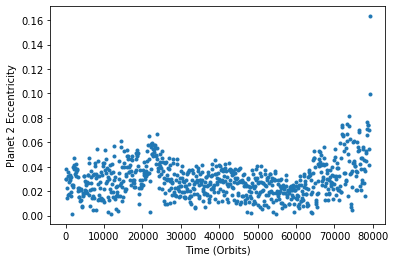

In [9]:
import rebound
import matplotlib.pyplot as plt
%matplotlib inline

sa = rebound.SimulationArchive('test.bin')
times, e = [], []
for sim in sa:
    times.append(sim.t)
    e.append(sim.particles[2].e)
    
fig, ax =plt.subplots()
ax.plot(times, e, '.')
ax.set_xlabel('Time (Orbits)')
ax.set_ylabel('Planet 2 Eccentricity')

In the case of a collision, the archive will also append a final snapshot of the state at collision:

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fda205b0510>)

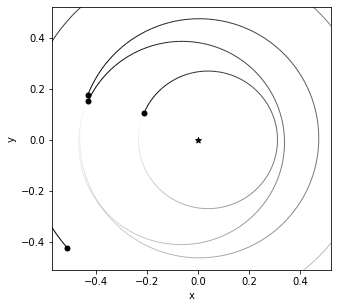

In [10]:
rebound.OrbitPlot(sa[-1])

See https://github.com/hannorein/rebound/blob/master/ipython_examples/SimulationArchive.ipynb and https://github.com/hannorein/rebound/blob/master/ipython_examples/SimulationArchiveRestart.ipynb for more details.

# Going Further

The `Nbody` wrapper provides minimal functionality for easy comparisons to N-body integrations. If you want to go further you can always set integration parameters and run it yourself. 

For reference, all classes in SPOCK initialize simulation parameters with the `init_sim_parameters` function in spock/spock/simsetup.py. It:

* sets the timestep to 5% of the shortest pericenter passage time among all planets (Wisdom 2015)
* sets the integrator to WHFast (switches to IAS15 if e > 0.99, avoiding prohibitively short WHFast timestep)
* initializes MEGNO and sets collision detection
* overwrites any existing particle radii with their individual Hill radii for collision detection
* moves to the center-of-mass frame
* sets ri_whfast.safe_mode to 1

In particular, if you don't want to calculate the MEGNO and understand the consequences (https://github.com/hannorein/rebound/blob/master/ipython_examples/AdvWHFast.ipynb), you can skip `sim.init_megno()` and set `ri_whfast.safe_mode` to 0 to gain > a factor of two in computation time.

However, planetary systems are generally chaotic. If you do this (or change other parameters), you will not get the same chaotic realization of the trajectory as `StabilityClassifier` and `Nbody`. In principle this is not a problem, since each chaotic realization is equally valid, but is something to keep in mind when wondering why one Nbody integration collides at 1e4 orbits and another at 5e4 (see Hussain & Tamayo 2019 for how instability times are typically distributed). 

We have tested in particular that the `StabilityClassifier` trained with a slightly different timestep than our N-body integrations (thus sampling different chaotic realizations) has the same performance as one trained using the exact same timestep and trajectories.